In [ ]:
# Initial imports
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.ensemble import GradientBoostingClassifier
%matplotlib inline
from sklearn import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt

# Needed for decision tree visualization
import pydotplus
from IPython.display import Image

2021-08-18 02:22:52.046335: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-08-18 02:22:52.046396: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [ ]:
# Set path to CSV and read in CSV
df1=pd.read_csv(Path('/work/Fintech-Project2/STRATEGY NOTEBOOKS/Daily Strategies/XRP_DAILY_MACD_TRADE_STRATEGY.CSV'), infer_datetime_format=True, index_col='Date')
df1.drop(columns = ['macd','signal','macd_position'], inplace = True)
df2=pd.read_csv(Path('/work/Fintech-Project2/STRATEGY NOTEBOOKS/Daily Strategies/XRP DAILY AROON 25 TRADE STRATEGY.CSV'), infer_datetime_format=True, index_col='Date')
df2.drop(columns =['trend_aroon_up','trend_aroon_down', 'aroon_position', 'Close'],inplace = True)
df3=pd.read_csv(Path('/work/Fintech-Project2/STRATEGY NOTEBOOKS/Daily Strategies/XRP_DAILY_RSI_TRADE_STRATEGY.CSV'), infer_datetime_format=True, index_col='Date')
df3.drop(columns = ['RSI','rsi_position','Close'], inplace = True)
df4=pd.read_csv(Path('/work/Fintech-Project2/STRATEGY NOTEBOOKS/Daily Strategies/XRP_AO_1d_TRADE_STRATEGY'), infer_datetime_format=True, index_col='Date')
df4.drop(columns = ['ao','ao_position','Close'], inplace = True)
combined_signals_df = pd.concat([df1,df2,df3,df4], axis = 1).fillna(0)
combined_signals_df

,Close,macd_signal,aroon_signal,rsi_signal,ao_signal
Date,,,,,
2019-09-01,0.258054,0,0,0,0.0
2019-09-02,0.260820,1,0,1,0.0
2019-09-03,0.263139,0,0,0,0.0
2019-09-04,0.259905,0,0,0,0.0
2019-09-05,0.256346,0,0,0,0.0
...,...,...,...,...,...
2021-08-07,0.816281,0,1,1,0.0
2021-08-08,0.778739,0,0,0,0.0
2021-08-09,0.818553,0,0,0,0.0


In [ ]:
#df1=pd.read_csv(Path('/work/Fintech-Project2/TRADE_STRATS/XRP_MACD_TRADE_STRATEGY'), infer_datetime_format=True, index_col='Datetime')
#df1

In [ ]:
#df2=pd.read_csv(Path('/work/Fintech-Project2/TRADE_STRATS/XRP AROON 25 TRADE STRATEGY.CSV'), infer_datetime_format=True, index_col='Unnamed: 0')
#df2

In [ ]:
#df3=pd.read_csv(Path('/work/Fintech-Project2/TRADE_STRATS/XRP_RSI_TRADE_STRATEGY'), infer_datetime_format=True, index_col='Datetime')
#df3

In [ ]:
combined_signals_df['Returns'] = combined_signals_df.Close.pct_change()
combined_signals_df

,Close,macd_signal,aroon_signal,rsi_signal,ao_signal,Returns
Date,,,,,,
2019-09-01,0.258054,0,0,0,0.0,NaN
2019-09-02,0.260820,1,0,1,0.0,0.010719
2019-09-03,0.263139,0,0,0,0.0,0.008891
2019-09-04,0.259905,0,0,0,0.0,-0.012290
2019-09-05,0.256346,0,0,0,0.0,-0.013694
...,...,...,...,...,...,...
2021-08-07,0.816281,0,1,1,0.0,0.093459
2021-08-08,0.778739,0,0,0,0.0,-0.045992
2021-08-09,0.818553,0,0,0,0.0,0.051126


In [ ]:
# Construct the dependent variable where if daily return is greater than 0, then 1, else, 0.
combined_signals_df['Binary Return'] = np.where(combined_signals_df['Returns'] > 0.0, 1.0, 0.0)

In [ ]:
# Shift DataFrame values by 1
combined_signals_df[['aroon_signal','macd_signal','rsi_signal']] = combined_signals_df[['aroon_signal','macd_signal','rsi_signal']].shift(1)
combined_signals_df[['aroon_signal','macd_signal','rsi_signal']].tail()

,aroon_signal,macd_signal,rsi_signal
Date,,,
2021-08-07,0.0,0.0,0.0
2021-08-08,1.0,0.0,1.0
2021-08-09,0.0,0.0,0.0
2021-08-10,0.0,0.0,0.0
2021-08-11,0.0,0.0,0.0


In [ ]:
# Drop NAs and replace positive/negative infinity values
# combined_signals_df.dropna(subset=combined_signals_df[['aroon_signal','macd_signal','rsi_signal']], inplace=True)
# combined_signals_df.dropna(subset=combined_signals_df['Returns'], inplace=True)
# combined_signals_df = combined_signals_df.replace([np.inf, -np.inf], np.nan)
# combined_signals_df.head()

combined_signals_df[['aroon_signal', 'macd_signal', 'rsi_signal']].dropna( inplace = True)
combined_signals_df = combined_signals_df.replace([np.inf, -np.inf], np.nan)
combined_signals_df.dropna(inplace = True)
# combined_signals_df[['aroon_signal', 'macd_signal', 'rsi_signal']].astype('int64')
combined_signals_df[['aroon_signal', 'macd_signal', 'rsi_signal', 'Binary Return']]=combined_signals_df[['aroon_signal', 'macd_signal', 'rsi_signal', 'Binary Return']].astype(int)
combined_signals_df.dropna(inplace = True)
combined_signals_df

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,Close,macd_signal,aroon_signal,rsi_signal,ao_signal,Returns,Binary Return
Date,,,,,,,
2019-09-02,0.260820,0,0,0,0.0,0.010719,1
2019-09-03,0.263139,1,0,1,0.0,0.008891,1
2019-09-04,0.259905,0,0,0,0.0,-0.012290,0
2019-09-05,0.256346,0,0,0,0.0,-0.013694,0
2019-09-06,0.252340,0,0,0,0.0,-0.015627,0
...,...,...,...,...,...,...,...
2021-08-07,0.816281,0,0,0,0.0,0.093459,1
2021-08-08,0.778739,0,1,1,0.0,-0.045992,0
2021-08-09,0.818553,0,0,0,0.0,0.051126,1


In [ ]:
# Construct training start and end dates
training_start = combined_signals_df.index.min()
training_end = '2021-08-10'

# Construct testing start and end dates
testing_start =  '2019-09-01'
testing_end = combined_signals_df.index[-2]

# Print training and testing start/end dates
print(f"Training Start: {training_start}")
print(f"Training End: {training_end}")
print(f"Testing Start: {testing_start}")
print(f"Testing End: {testing_end}")

Training Start: 2019-09-02
Training End: 2021-08-10
Testing Start: 2019-09-01
Testing End: 2021-08-10


In [ ]:
# Construct the X_train and y_train datasets
X_train = combined_signals_df[['aroon_signal','macd_signal','rsi_signal']][training_start:training_end]
y_train = combined_signals_df['Binary Return'][training_start:training_end]

X_train.tail()

,aroon_signal,macd_signal,rsi_signal
Date,,,
2021-08-06,0,0,0
2021-08-07,0,0,0
2021-08-08,1,0,1
2021-08-09,0,0,0
2021-08-10,0,0,0


In [ ]:
# Construct the X test and y test datasets
X_test = combined_signals_df[['aroon_signal','macd_signal','rsi_signal']][testing_start:testing_end]
y_test = combined_signals_df['Binary Return'][testing_start:testing_end]

X_test.tail()

,aroon_signal,macd_signal,rsi_signal
Date,,,
2021-08-06,0,0,0
2021-08-07,0,0,0
2021-08-08,1,0,1
2021-08-09,0,0,0
2021-08-10,0,0,0


In [ ]:
# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
model = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0)
model.fit(X_train, y_train)

# Make a prediction of "y" values from the X_test dataset
predictions = model.predict(X_test)

# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
Results = y_test.to_frame()
Results["Predicted Value"] = predictions
Results

,Binary Return,Predicted Value
Date,,
2019-09-02,1,1
2019-09-03,1,1
2019-09-04,0,1
2019-09-05,0,1
2019-09-06,0,1
...,...,...
2021-08-06,1,1
2021-08-07,1,1
2021-08-08,0,0


In [ ]:
predictions = model.predict(X_test)
predictions

array([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

<AxesSubplot:xlabel='Date'>

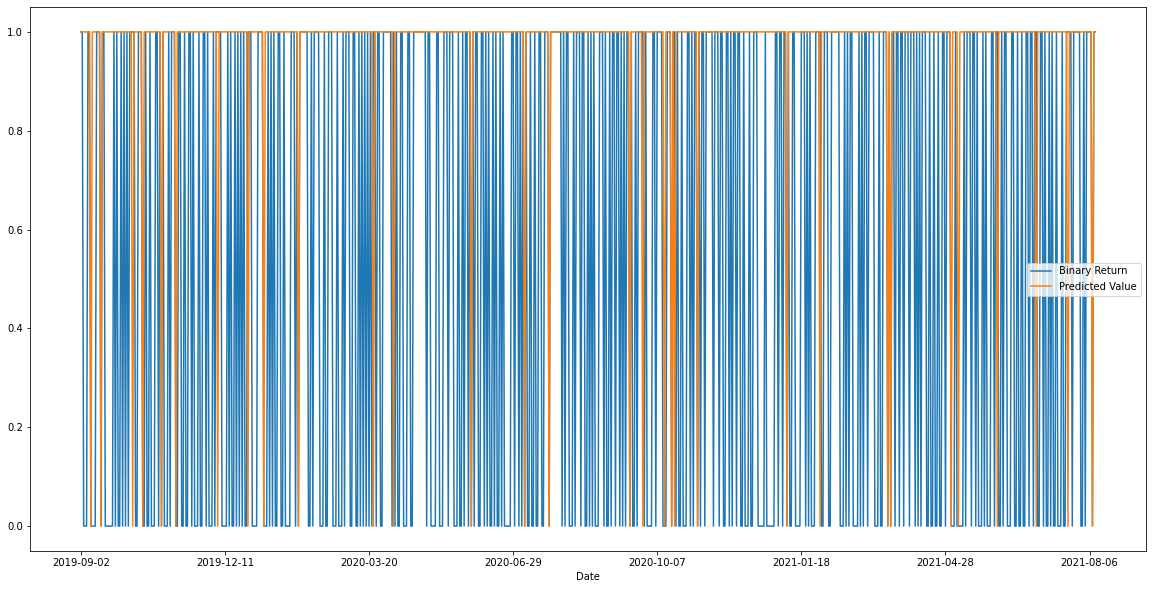

In [ ]:
# Plot predicted results vs. actual results
Results[['Binary Return', 'Predicted Value']].plot(figsize=(20,10))

<AxesSubplot:xlabel='Date'>

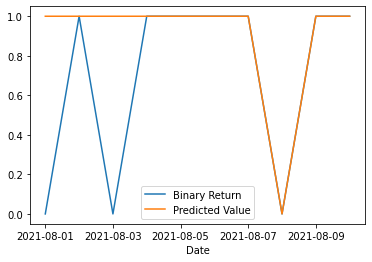

In [ ]:
# Plot last 10 records of predicted vs. actual results
Results[['Binary Return', 'Predicted Value']].tail(10).plot()

In [ ]:
# Replace predicted values 0 to -1 to account for shorting
Results['Predicted Value'].replace(0, -1, inplace=True)
Results

,Binary Return,Predicted Value
Date,,
2019-09-02,1,1
2019-09-03,1,1
2019-09-04,0,1
2019-09-05,0,1
2019-09-06,0,1
...,...,...
2021-08-06,1,1
2021-08-07,1,1
2021-08-08,0,-1


<AxesSubplot:xlabel='Date'>

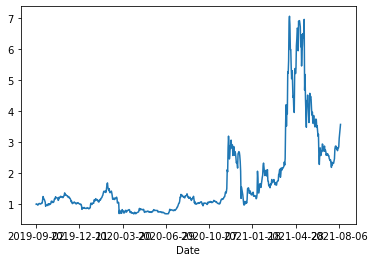

In [ ]:
# Calculate cumulative return of model and plot the result
(1 + (combined_signals_df['Returns'] * Results['Predicted Value'])).cumprod().plot()

In [ ]:
initial_capital = 100000

initial_buy_amount = initial_capital / combined_signals_df['Close'].iloc[0]
# initial_buy_amount

hold_value = initial_buy_amount * combined_signals_df['Close'].iloc[-2]
# hold_value

buy_hold_profit = (hold_value - initial_capital)/(initial_capital)*100
buy_hold_profit

226.37336406881113

In [ ]:
hold_value

326373.3640688111

In [ ]:
combined_signals_df['Close'].iloc[0]
combined_signals_df['Close'].iloc[-2]

0.8512470126152039

In [ ]:
# Set initial capital allocation
initial_capital = 100000

# Plot cumulative return of model in terms of capital
cumulative_return_capital = initial_capital * (1 + (combined_signals_df['Returns'] * Results['Predicted Value'])).cumprod().to_frame()
cumulative_return_capital

,0
Date,
2019-09-02,101071.873822
2019-09-03,101970.526126
2019-09-04,100717.300382
2019-09-05,99338.122650
2019-09-06,97785.734950
...,...
2021-08-07,312879.705747
2021-08-08,327269.534412
2021-08-09,344001.595005


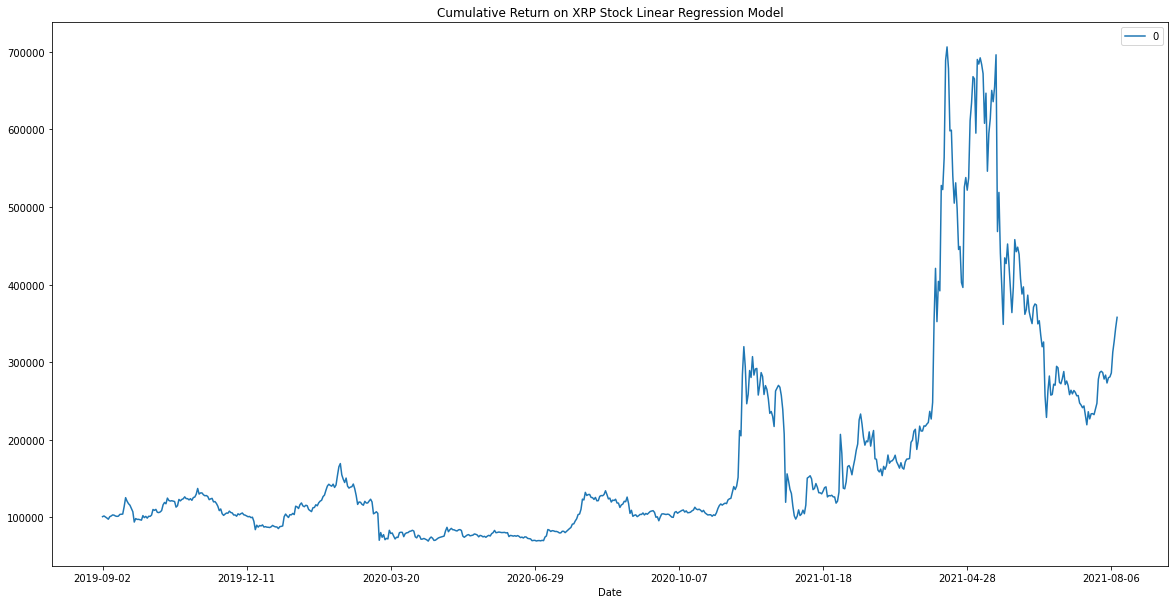

In [ ]:
# Set initial capital allocation
initial_capital = 100000

# Plot cumulative return of model in terms of capital
cumulative_return_capital = initial_capital * (1 + (combined_signals_df['Returns'] * Results['Predicted Value'])).cumprod().to_frame()
returns_plot = cumulative_return_capital.plot(figsize = (20,10), title = 'Cumulative Return on XRP Stock Linear Regression Model')
cumulative_return_capital.to_csv('cumulative return on xrp.csv')

In [ ]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)
acc_score

0.5290780141843971

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d12c285c-6789-4c45-9ad7-1be9b4d60622' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>